## Training a MF Model through User and Movie Embeddings

In [1]:
# Setup. Import libraries and load dataframes for Movielens data.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
from keras.models import model_from_json, load_model
import os
import random
import time

# Set random seeds for reproducibility
tf.set_random_seed(1); 
np.random.seed(1); 
random.seed(1) 

/Users/akhilpunia/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# setting data path
input_dir = 'data/ml-latest/'
ratings_path = os.path.join(input_dir, 'ratings.csv')

# loading ratings data
ratings_df = pd.read_csv(ratings_path, usecols=['userId', 'movieId', 'rating'])

In [3]:
## Global Average Ratings across All Users
av_rating = np.mean(ratings_df.rating)
print("Average Rating across all users {0:.03f}".format(av_rating))

## Center around Global Mean ['y_g']
ratings_df['y_g'] = ratings_df.rating - av_rating

## Combining the Movies Title as a Special Column
movies_df = pd.read_csv(os.path.join(input_dir, 'movies.csv'), usecols=['movieId', 'title'])

df = ratings_df.merge(movies_df, on='movieId').sort_values(by='userId')
df = df.sample(frac=1, random_state=1) # Shuffle

df.sample( 5, random_state = 1 )

Average Rating across all users 3.530


,userId,movieId,rating,y_g,title
2945217,205212,480,5.0,1.469555,Jurassic Park (1993)
3182468,68964,541,4.0,0.469555,Blade Runner (1982)
12749097,44970,1249,4.0,0.469555,"Femme Nikita, La (Nikita) (1990)"
24843782,83922,165549,4.0,0.469555,Manchester by the Sea (2016)
11976545,144157,337,4.0,0.469555,What's Eating Gilbert Grape (1993)


In [4]:
n_movies = len(df.movieId.unique())
n_users = len(df.userId.unique())

print("{1:,} distinct users rated {0:,} different movies (total ratings = {2:,})"
      .format(n_movies, n_users, len(df)))

283,228 distinct users rated 53,889 different movies (total ratings = 27,753,444)


In [5]:
movie_embedding_size = user_embedding_size = 8

# Each instance consists of two inputs: a single user id, and a single movie id
user_id_input = keras.Input(shape=(1,), name='user_id')
movie_id_input = keras.Input(shape=(1,), name='movie_id')
user_embedded = keras.layers.Embedding(df.userId.max()+1, user_embedding_size, 
                                       input_length=1, name='user_embedding')(user_id_input)
movie_embedded = keras.layers.Embedding(df.movieId.max()+1, movie_embedding_size, 
                                        input_length=1, name='movie_embedding')(movie_id_input)

dotted = keras.layers.Dot(2)([user_embedded, movie_embedded])
out = keras.layers.Flatten()(dotted)

model = keras.Model(
    inputs = [user_id_input, movie_id_input],
    outputs = out,
)
model.compile(
    tf.train.AdamOptimizer(0.001),
    loss='MSE',
    metrics=['MAE'],
)
model.summary(line_length=88)

________________________________________________________________________________________
Layer (type)                 Output Shape       Param #   Connected to                  
user_id (InputLayer)         (None, 1)          0                                       
________________________________________________________________________________________
movie_id (InputLayer)        (None, 1)          0                                       
________________________________________________________________________________________
user_embedding (Embedding)   (None, 1, 8)       2265832   user_id[0][0]                 
________________________________________________________________________________________
movie_embedding (Embedding)  (None, 1, 8)       1551096   movie_id[0][0]                
________________________________________________________________________________________
dot_1 (Dot)                  (None, 1, 1)       0         user_embedding[0][0]          
                     

In [6]:
history = model.fit(
    [df.userId, df.movieId],
    df.y_g,
    batch_size=5000,
    epochs=20,
    verbose=0,
    validation_split=.1,
);

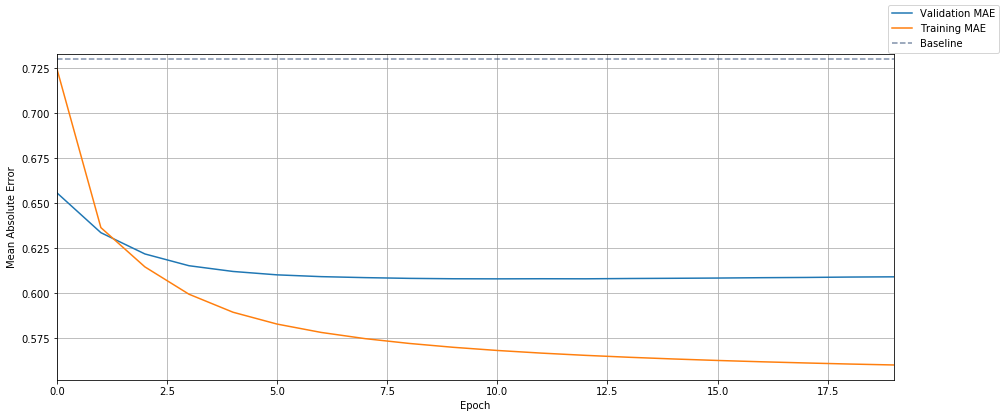

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(history.epoch, history.history['val_mean_absolute_error'], label='Validation MAE')
ax.plot(history.epoch, history.history['mean_absolute_error'], label='Training MAE')
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Absolute Error')
ax.set_xlim(left=0, right=history.epoch[-1])
baseline_mae = 0.73
ax.axhline(baseline_mae, ls='--', label='Baseline', color='#002255', alpha=.5)
ax.grid()
fig.legend();
plt.show()

In [8]:
model.save('movie_mf_model_32.h5')

/Users/akhilpunia/anaconda/envs/py36/lib/python3.6/site-packages/keras/models.py:139: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '
